# SC3011TN - Stochastische Signaalanalyse - 2020/2021

## Python Template

This is the template for for the second Python assignment given in the course SC3011TN. In this exercise, we will use a FIR Wiener filter to denoise signals, which were obtained by sending and recording with Arduino microcontrollers. Due to the COVID-measures, we can sadly not allow you to record signals yourself, so this year we have recorded signals for you and you are tasked solely with filtering the signals. Use this template to answer the questions. 

### How to use the template
As you will see there are two types of cells in this Jupyter Notebook, **Python** cells indicated with `In [ ]:` and **Markdown** cells that have no marking to the left of the cell. For the **Markdown** cells you have to click on the text itself (indicated throughout the text with 'Click here to type your answer').

1. The **Python** cells work in the usual way, enter your code and press `Shift Enter` to run the cell, the output will be displayed below the cell. Variables and functions will be accessible by the other cells after you have run the code. 

2. The **Markdown** cells use the **Markdown** type setting language. This is a very simple type setting system. Check the [Cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) for a overview of the comments. Furthermore, **Markdown** works with **LaTeX** math, `$ $` for inline equations and `$$ $$` for centered equations. Press `Shift Enter` to compile the text.

After you have answered the questions and are finished with the assignment, you can export the **Jupyter Notebook** as a PDF. Go to the top left, click on `File` then `Download As` and Choose **PDF**. If this feature is not supported by your system, you can also choose **LaTeX**. Then you Download a **LaTeX** project. You can then use your preferred **LaTeX** compiler to create the **PDF**.   

**NB: Please remove this part of the notebook before submitting in your assignment**

# Group details

 **Student 1**:
 
     Name: ...
     
     Student number: ...

 **Student 2**: 
 
     Name: ... 
     
     Student number: ...

 **Date of completion**: ...

## Introduction

In this exercise, we consider an RF communication system consisting of an emitter and a receiver.
Interference originating from the RF environment and from thermal noise of the system cause signal degradation at the receiver.
Since the nature of these aberrations is stochastic, Wiener filtering can be used to subtract the effects of the distortion.

In the configuration of the figure below, all signals are discrete-time and real.
The corrupted signal $x(n) = d(n) + v(n)$ contains both the signal of interest $d(n)$ and noise $v(n)$, which is uncorrelated to d(n).
In this assignment you will design a FIR filter $W(z)$, used to estimate the ground truth signal from $x(n)$ and from the statistical properties of the noise.

![alt text][anc]

[anc]: ./denoising-scheme.JPG

## Reporting


You are required to hand-in a report, showing your results and answering the questions about this exercise. Python scripts should be included as text in your report. Do not forget to change the amount of interacting stars according to your student number, as no points can be awarded otherwise.

To help you with reporting, you can use this Jupyter notebook as your report. We strongly encourage using the notebook, as hints are already provided for you. After you have answered the questions and are finished with the assignment, you can export the Jupyter notebook as a PDF (File > Download as > LaTeX or PDF).

The report or exported Jupyter notebook should be dated and handed in before the deadline (see Course Schedule on Brightspace). The report should be handed in digitally by only one group member, but make sure the names and student numbers of all group members are included in the report or exported Jupyter notebook.

## First steps

Make sure that the files `Audio.py`, `Communication.py` and `denoising-scheme.jpg`, as well as the recorded signals `gong_5cm.mat`, `gong_100cm.mat`, `gong_250cm.mat` and `noise.mat` are included in the same directory as this Jupyter notebook. Run the following code:

In [1]:
! pip install pyserial
! pip install sounddevice
! pip install scipy

**Note:** You only need to execute this code snippet once, after that your python will permanently include the modules. If the the code gives an error, manually install the modules using pip in the command prompt. In Windows: start button->search, type cmd->`pip install package_name`

# Obtaining the data

In this section, you will import data from the transmission experiment, described in the introduction. As the COVID-measures prevent us from letting you record your own signals, we have done the experiment for you and we provide you with the raw recordings. Before doing so, we describe the experimental setup that we used to record the signals. The experimental setup is shown in the figure below. 

![alt text][anc]

[anc]: ./experimentalsetup.png

For this experiment, two Arduino MK1000's are used. These Arduino microcontrollers are able to send and receive signals through radio frequency (RF) wireless transmission. As such, the first microcontroller is configured as a sender, used to send a wav-file `gong.wav`. The second microcontroller is configured as a receiver and it is linked to the sender. By simultaneously activating both microcontrollers, the receiver will record the signal sent by the sender.

However, the signal transmission is affected by RF noise. Examples of sources of this noise are disturbances in the RF band, distance-dependent noise caused by the distance between the microcontrollers and thermal distortion of the signal. These noise sources act additively on the sent signal `gong.wav`. For distances of 5 cm, 100 cm and 250 cm between the microcontrollers, we recorded `gong_5cm.mat`, `gong_100cm.mat` and `gong_250cm.mat` respectively, which you can listen to later in this assignment.

To filter the noise from the signal using denoising, we also need a
recording of the noise for every distance of 5 cm, 100 cm and 250 cm
between the microcontrollers. The total noise has a complicated spectrum, so to save
you some mathematical work we solely focus on ambient,
distance-independent noise. This noise is assumed to be zero-mean and white, and a measurement of this noise is contained in `noise.mat`.

NB. The recorded values in `gong_5cm.mat`, `gong_100cm.mat`, `gong_250cm.mat` and `noise.mat` are expressed in decibels relative to full scale (dB-FS), which is a unit used to expressed signal amplitudes in digital systems.

With these signals, you have enough information to calculate the weights of a FIR Wiener filter. This assignment will guide you through this process.

### Play the signal

During the assignment, you will want to listen to the raw and filtered signals. The function `play_signal` can be used for this. Run the cell below to define the function.

In [1]:
#import sounddevice as sim
import sounddevice as sd

# function for playing a signal
# You can use it further if you want to listen smth

def play_signal( signal ):
    sd.play( signal.astype('int16'), 22050 )

### Loading files


Run this section in order to load the .mat files with the noise audios and the background noise signals.

In [2]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# modeling distance in centimeters (cm)
distances = np.array( [5.0, 100.0, 250.0] )

# number of experiments with different distances
N_exp = distances.shape[0]

print( f'Number of experiments = {N_exp}' )

# list of files for all distance experiments with audio
filenames = ['gong_5cm.mat', 'gong_100cm.mat', 'gong_200cm.mat']

# Number of data points
N = len( sio.loadmat( filenames[0] )['audio'][0] )

# create array with received audio signals
data_noised = np.zeros( (N_exp, N), dtype=float )
for iexp in range(N_exp):
    data_noised[iexp] = sio.loadmat( filenames[iexp] )['audio'][0]

# array for the time steps
time_steps = np.linspace( 0, N-1, N ).astype( int )
print( f'\nN = {N}' )

Number of experiments = 3

N = 65411


In [3]:
# load background noise signal that was measured

filename_noise = 'noise.mat'
data_mat = sio.loadmat( filename_noise )['audio'][0]

Nnoise = len( data_mat )
noise_measured = np.array( data_mat, dtype=float )

print( f'Number of noise time steps = {Nnoise}' )

Number of noise time steps = 88200


# Exercises
This part should be handled after all audio files were uploaded into *data_noised* array and the noise was uploaded into *noise_measured* file.

## Question 1

Formulate the denoising problem as a Minimum Variance FIR Wiener Problem, using the symbols $x(n)$, $v(n)$, $d(n)$, $\hat{d}(n)$, $e(n)$ as in the figure presented in the **Introduction**. In particular
* Explain for each variable what signal they represent
* Write the cost function $J(W(z))$ and the optimization problem that should be solved to find the Minimum Variance FIR Wiener Filter.

Note that no numerical values are required, but you need to specify the meaning of all the symbols and their relation to the sent and received data. **(2 points)**

### Answer 1

$d(n) =$ signal of interest \
$v(n) =$ ZMWN that corrupts received signal \
$x(n) =$ the signal received by the receiver \
$\hat{d}(n) =$ the received signal flitered by the Wiener filter with transfer function $W(z)$ \
$e(n) =$ the error, it denotes the difference between the actual signal and the received signal filtered by $W(z)$

Cost function: $ J(W(z)) = E[|d(n) - \hat{d}(n)|^2]  $
               $ = E[|e(n)|^2]  $



XXX Pending XXX


## Question 2

Plot the received audio signals and the received noise signal. You can plot all the audio signals in the same figure, but use a separate plot for the noise signal. Do not forget to label the axes and to provide a legend. **(1 point)**

NB. The recorded values in `gong_5cm.mat`, `gong_100cm.mat`, `gong_250cm.mat` and `noise.mat` are expressed in decibels relative to full scale (dB-FS).

### Answer 2

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

Text(0, 0.5, 'dB-FS')

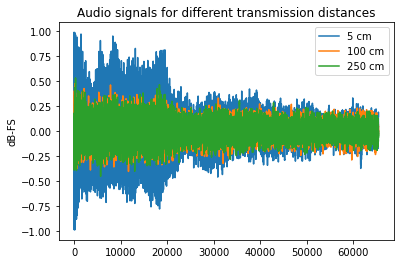

In [4]:
# plot noised audio signal


plt.plot(data_noised[0]*2**(-15), label= '5 cm')
plt.plot(data_noised[1]*2**(-15), label='100 cm')
plt.plot(data_noised[2]*2**(-15), label='250 cm')
plt.legend()
plt.title('Audio signals for different transmission distances')
plt.ylabel('dB-FS')








In [5]:
# listen the noised audio signals
# Warning to headphone users: depending on your own sound configurations, the played signal may be very loud! 
# Turn down your volume the first time you try playing a signal.

ind_to_listen = 2 #Choose 0 (5 cm), 1 (100 cm) or 2 (250 cm). 
play_signal( data_noised[2] )

PortAudioError: Error querying device -1

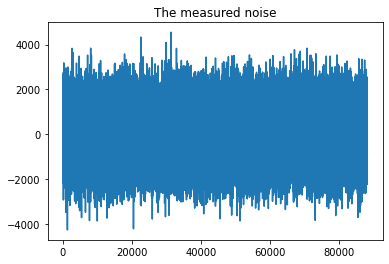

In [6]:
# plot the measured noise signal

plt.title('The measured noise')
plt.plot(noise_measured)


## Question 3

Determine the Wiener-Hopf equation for the denoising case with filter order $m$. Clearly specify the size and content of all quantities involved.

What assumptions are we making for the (true and noised) audio signal and the noise in order to obtain the weights of the filter $w$?

Derive how can we calculate the right hand side of the Wiener-Hopf equation, assuming that we know $r_x(k), \; \forall k$ 
and the noise variance $\sigma^2_v$. **(2 points)**

### Answer 3

$R_x \hat{w} = r_{dx} $ \



$R_x = E[x^*(n)x(n)^T]$: covariance matrix of vector $x(n)$, it has a  size of $m \times m$ 

$x(n)$: The vector with the received datapoints from the present ($t=n$) to $m$ values back in the past($t = n-m+1$) 

$\hat{w}$: Vector containing the parameters of the Wiener filter (length $m$)

$r_{dx} = E[d(n)x^*(n)]$ : The cross correlation with a zero lag of the signal of interest $d(n)$ and the received datapoints $x(n)$ from the present ($t=n$) to $m$ values back in the past ($t = n-m+1$) 


XXX Pending XXX

## Question 4

Estimate the mean and variance ($\sigma^2_v$) of the measured noise. Print these estimates. **(1 point)**

### Answer 4

$\hat{m}_v = -0.713$

$\hat{\sigma}^2_v = 9.94 \cdot 10^5$

In [7]:
# estimate the mean and variance of the measured noise
from IPython.display import display, Math

noise_mean = np.average(noise_measured)
noise_var = np.average((noise_measured-noise_mean)**2)

display(Math((r'\hat{m}_v = %.3e,  \; \; \hat{\sigma}^2_v = %.3e' %(noise_mean, noise_var))))

<IPython.core.display.Math object>

## Question 5

1. Assuming the audio signals are ergodic, calculate the auto-correlation function $r_x(k)$ of every received audio signal for lags $0,\dots,9$. Print these values. **(2 points)**

2. Calculate the cross-correlation function $r_{dx}(k)$ of every received audio signal for lags $0,\dots,9$. Print these values. **(1 point)**

3. Using the formula below, compute and plot the auto-correlation of the noise $v(n)$ for lags $0,\dots,9$. Is the noise ZMWN? Explain your answer. **(1 point)**

**Note:** if the signal $x(n)$ is auto-correlation ergodic,
the auto-correlation function $r_x(k)$ can be estimated as
(if we have only values $x_1, x_2, \dots, x_N$):
$$
    r_x(k) = \frac{1}{N-k} \sum_{i=k+1}^{N} x(i) x^*(i-k)
$$

### Answer 5

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

Table for r_x(k) 

  k         50cm        100cm        200cm
---  -----------  -----------  -----------
  0  4.25393e+07  9.2997e+06   9.52128e+06
  1  4.14259e+07  8.65364e+06  8.87586e+06
  2  4.02718e+07  8.35578e+06  8.57613e+06
  3  3.87734e+07  7.99334e+06  8.20458e+06
  4  3.68007e+07  7.59432e+06  7.80073e+06
  5  3.46727e+07  7.17164e+06  7.36523e+06
  6  3.24518e+07  6.75583e+06  6.92713e+06
  7  3.02276e+07  6.3367e+06   6.48961e+06
  8  2.8042e+07   5.92169e+06  6.06339e+06
  9  2.59319e+07  5.53415e+06  5.6539e+06


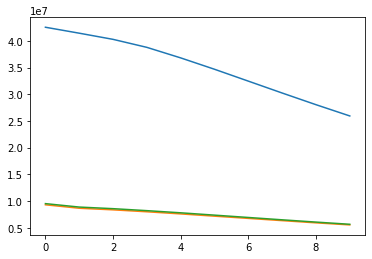

In [8]:
# calculating the auto-correlation function for the audio signals
from tabulate import tabulate


X = data_noised
r_x = np.zeros((3,10))

for i in range(10):
    k = i
    N = len(data_noised[0])
    r_x[:,i] = 1/(N-k) *np.sum(X[:,k:]*X[:,:(N-k)], axis=1)
    
plt.plot(r_x.T)
table = np.zeros((10,4))
table[:,1:] = r_x.T
table[:,0] = np.arange(10)
Headers = ["k","50cm","100cm","200cm"]
print("Table for r_x(k) \n")
print(tabulate(table, headers=Headers))

In [9]:
# calculating the auto-correlation function for the noise
X = noise_measured
r_v = np.zeros(10)

for i in range(10):
    k = i
    N = len(noise_measured)
    r_v[i] = 1/(N-k) *np.sum(X[k:]*X[:(N-k)])
    
table = np.zeros((10,2))
table[:,1] = r_v.T
table[:,0] = np.arange(10)
Headers = ["k","r_v(k)"]
print("Table for r_v(k) \n")
print(tabulate(table, headers=Headers))

Table for r_v(k) 

  k      r_v(k)
---  ----------
  0  993765
  1   -1494.5
  2    4070.83
  3   -2920
  4   -4399.76
  5     158.426
  6     625.851
  7   -3770.77
  8    1334.58
  9    1170.53


In [10]:
# calculating the cross-correlation function r_dx
r_dx = np.zeros((3,10))

for i in range(10):
    r_dx[:,i] = r_x[:,i]- r_v[i]
    
table = np.zeros((10,4))
table[:,1:] = r_dx.T
table[:,0] = np.arange(10)
Headers = ["k","50cm","100cm","200cm"]
print("Table for r_dx(k) \n")
print(tabulate(table, headers=Headers))

Table for r_dx(k) 

  k         50cm        100cm        200cm
---  -----------  -----------  -----------
  0  4.15455e+07  8.30594e+06  8.52752e+06
  1  4.14274e+07  8.65513e+06  8.87735e+06
  2  4.02677e+07  8.3517e+06   8.57206e+06
  3  3.87763e+07  7.99626e+06  8.2075e+06
  4  3.68051e+07  7.59872e+06  7.80513e+06
  5  3.46726e+07  7.17148e+06  7.36507e+06
  6  3.24512e+07  6.7552e+06   6.9265e+06
  7  3.02314e+07  6.34047e+06  6.49338e+06
  8  2.80406e+07  5.92035e+06  6.06205e+06
  9  2.59307e+07  5.53298e+06  5.65273e+06


## Question 6

Using a 10-th order FIR Wiener filter, calculate the optimal filter coefficients for every received audio signal. Print these values. **(2 points)**

 **Hint:** The `scipy.linalg.toeplitz()` function may be useful.

### Answer 6

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

In [11]:
# obtaining the optimal Wiener filter coefficients
import scipy.linalg as lin

## Question 7

Using the computed filter coefficients, compute an estimate of the denoised audio signals from the received ones.
Plot together the denoised signal with the originally received one.
Create one plot for every audio signal.

Use the *play_signal()* function to play the denoised signals - do you hear the difference between the originally received and the denoised one? **(3 points)**

**Hint:** the *scipy.signal.lfilter()* function can be useful when using the Wiener filter. You can compare your solution to the *scipy.signal.wiener()* function, which uses its own estimate of the noise instead of the noise measurement. Do you notice any differences?

### Answer 7

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

In [14]:
# applying the Wiener filter to the problem
import scipy.signal as sig

In [15]:
# listen the noised and denoised audio signals
import time

# index of the experiment that we want to hear
ind_to_hear = 2

# signal with noise
play_signal( data_noised[ind_to_hear] )

# timer to wait for some time between sounds
time.sleep(3)

# denoised signal
play_signal(  )

PortAudioError: Error querying device -1

In [ ]:
# plot the noised and denoised signals together

## Question 8

1. To investigate the effect of the filter order on the denoising, vary the filter order between $m = 2$ and $m = 20$. 
   For what distance and for what filter order do you have the best denoised audio signal? Justify your answer. **(1 point)**
   
2. Denote the best denoised signal from item "a." as $d(n)$, and calculate the cost function $J$ of the Wiener problem assuming this signal is the ground truth. Print best filter order and the its respective cost function value for every received denoised audio signal. **(1 point)**
   
3. Plot the filter order (from $m=2$ to $m=20$) versus cost function value for all received signals. **(1 point)**

### Answer 8

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

In [ ]:
# use different Wiener filter orders

In [ ]:
# plot the best denoised signal, which we will take to be the ground truth

In [ ]:
# play the audio signal that is considered as ground truth

In [ ]:
# calculating the cost function

In [ ]:
# plot cost functions as a function of the filter order

## Question 9 (bonus)
This is an **optional** bonus question, in which you can earn bonus points to make up for any points you lost earlier during this exercise. Note that if you already have the maximum amount of points for this exercise (i.e. grade 10), any additional bonus points will be ignored (that is, they do not carry over to other exercises or the exam).

In this bonus question, we will characterize the signal over distance dependency by computing the signal-to-noise-ratio (SNR). For that:
1. Calculate the periodogram $P_d$ using the denoised audio signals only for the highest filter order from Question 8.
Calculate the periodogram $P_x$ using the noised audio signals (see section "*5.2.8 WSS Processes in the Frequency Domain*" in the lecture notes). Plot the **denoised** estimated power spectra. **(2 bonus points)**
**Hint:** be careful with the indexing. You can use *numpy.fft.fft()* and *numpy.fft.fftfreq()* functions.
          
2. SNR is the ratio between the **ground truth** audio signal energy and the noise energy.
The energy can be calculated as $E = \int_{-\infty}^{+\infty} P d\omega$. Approximating the integral by finite sum, calculate

   (a) the SNR of the denoised audio signals; 

   (b) the SNR of the noised audio signals. This can be done by relating the power spectrum of the noised signal with the power spectrum of the ground truth signal.

   In a single figure, plot these SNR values versus distance. **(2 bonus points)**


3. Are the graphs different? Explain why. **(1 bonus point)**

### Answer 9

Click here to type your answer. Type *Markdown* and LaTeX: $\alpha^2$.

In [13]:
import scipy.integrate as integrate

/mnt/c/Users/Jeroe/Documents/TU Delft/SC3011TN/Python I/ssa-env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 1000000000.0)

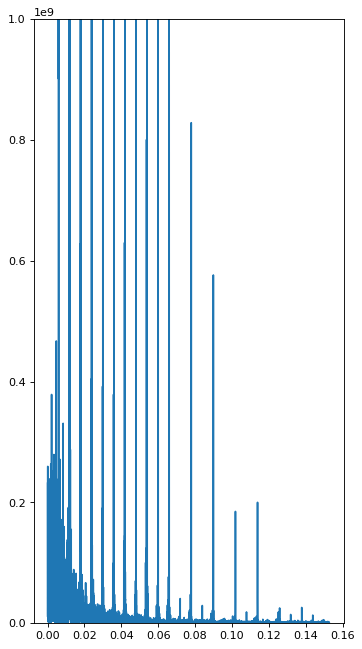

In [14]:
# calculating the periodogram for denoised audio signals
# and noised audio signals
# (estimation of the power spectrum)

import numpy.fft as fft
plt.rcParams["figure.dpi"] = 80


x50 = data_noised[0]
x100 = data_noised[1]
x200 = data_noised[2]

X50 = fft.fft(x50)
X50_freq = fft.fftfreq(len(x50))
P50 = 1/(2*len(x50)+1)*(X50*np.conj(X50))
E50 = integrate.simps(P50,X50_freq)


X100 = fft.fft(x100)
X100_freq = fft.fftfreq(len(x100))
P100 = 1/(2*len(x100)+1)*(X100*np.conj(X100))

X200 = fft.fft(x200)
X200_freq = fft.fftfreq(len(x200))
P200 = 1/(2*len(x200)+1)*(X200*np.conj(X200))


plt.gcf().set_size_inches(5,10)
plt.plot(X50_freq[0:int(1e4)], P50[0:int(1e4)])
plt.ylim([0,int(1e9)])
#plt.plot(X100_freq, P100)
#plt.plot(X200_freq, P200)


In [ ]:
# plot power spectrum values

In [15]:
# plot the SNR over distance
Noise = fft.fft(noise_measured)
Noise_freq = fft.fftfreq(len(noise_measured))
PNoise = 1/(2*len(noise_measured)+1)*(Noise*np.conj(Noise))
E_noise = integrate.simps(fft.fftshift(PNoise),fft.fftshift(Noise_freq))


E_50 = integrate.simps(fft.fftshift(P50),fft.fftshift(X50_freq))
SNR_50 = E50/E_noise

print(SNR_50)


(3053.576141175813+0j)
